In [1]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Restart the runtime (Runtime -> Restart Runtime) for any upgraded packages to take effect


NOTE: User is responsible for checking the content of datasets and the applicable licenses and determining if suitable for the intended use.
"""

# Install dependencies
# !pip install wget
# !apt-get install sox libsndfile1 ffmpeg libsox-fmt-mp3
# !pip install text-unidecode
# !pip install matplotlib>=3.3.2

## Install NeMo
BRANCH = 'main'
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""
# exit()

'\nRemember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!\nAlternatively, you can uncomment the exit() below to crash and restart the kernel, in the case\nthat you want to use the "Run All Cells" (or similar) option.\n'

# Finetuning CTC models on other languages

In previous tutorials, we have seen a few ways to restore an ASR model, set up the data loaders, and then either train from scratch or fine-tune the model on a small dataset. In this tutorial, we extend previous tutorials and discuss in detail how to * fine-tune a pre-trained model onto a new language*. While many of the concepts are similar to previous tutorials, this tutorial will dive deeper into essential steps. Namely,

 - Data preprocessing
 - Prepare tokenizers
 - Discuss how to fine-tune models on low-resource languages efficiently
 - Train a character encoding CTC model
 - Train a sub-word encoding CTC model

For this tutorial (and limited by the compute and storage available on Colab environments), we will attempt to fine-tune an English ASR model onto the [Mozilla Common Voice](https://commonvoice.mozilla.org/en) dataset for Japanese. This dataset will also allow us to discuss a few details for fine-tuning low-resource languages. The methods discussed here can also be applied to languages with several thousand hours of data!

**Note**: It is advised to review the execution flow diagram for ASR models in order to correctly setup the model prior to fine-tuning - [ASR CTC Examples](https://github.com/NVIDIA/NeMo/blob/main/examples/asr/asr_ctc/README.md)


In [2]:
import os
import glob
import subprocess
import tarfile
import wget
import copy
from omegaconf import OmegaConf, open_dict

In [3]:
data_dir = 'datasets/'

if not os.path.exists(data_dir):
  os.makedirs(data_dir, exist_ok=True)

if not os.path.exists("scripts"):
  os.makedirs("scripts")

In [4]:
import nemo
import nemo.collections.asr as nemo_asr
from nemo.collections.asr.metrics.wer import word_error_rate
from nemo.utils import logging, exp_manager

# Download dataset

We will use the NeMo script in the scripts directory to download and prepare the [Mozilla Common Voice (MCV)](https://commonvoice.mozilla.org/en) dataset for Japanese.

The data preparation script will download the audio files and respective transcripts and then process the audio into mono-channel 16 kHz wave files that can be easily used for training ASR models.

Why did we pick Japanese? Currently, the MCV Japanese dataset is tiny - a mere 2.5 hours of transcribed speech in total. Even when we combine the train and dev split to use for training, that amounts to less than 2 hours of transcribed speech. In addition to this, the Japanese vocabulary is massive, easily comprising several thousand unique tokens used in common vernacular. Compared to English, which has a mere 26 lower case characters as its alphabet, it imposes unique challenges when fine-tuning a model.

## Hugging Face

Now, let's download the Mozilla CommonVoice Spanish dataset. We will ignore the larger train file and get just the test part for the purposes of this tutorial. For good results, you will need to get the train files and likely other datasets too, bringing the total to over 1k hours.

Website steps:
- Visit https://huggingface.co/settings/profile
- Visit \"Access Tokens\" on list of items.
- Create new token - provide a name for the token and \"read\" access is sufficient.
  - PRESERVE THAT TOKEN API KEY. You can copy that key for next step.
- Visit the [HuggingFace Dataset page for Mozilla Common Voice 3.0](https://huggingface.co/datasets/mozilla-foundation/common_voice_3_0)
  - There should be a section that asks you for your approval.
  - Make sure you are logged in and then read that agreement.
  - If and only if you agree to the text, then accept the terms.

Code steps:
- Now below, run `login()`
- Paste your preserved HF TOKEN API KEY to the text box."

In [5]:
from huggingface_hub import login
login()

In [6]:
VERSION = "mozilla-foundation/common_voice_6_1"
LANGUAGE = "ja"

In [7]:
tokenizer_dir = os.path.join('tokenizers', LANGUAGE)
manifest_dir = os.path.join('datasets', LANGUAGE, VERSION, LANGUAGE)

In [8]:
# If something goes wrong during data processing, un-comment the following line to delete the cached dataset
# !rm -rf datasets/$LANGUAGE
!mkdir -p datasets

The following cell will download the Japanese MCV corpus, preprocess the audio and prepare manifest files that can be directly used by NeMo models.

We will use the `convert_hf_dataset_to_nemo.py` script located in the nemo/scripts/speech_recognition dir if you cloned NeMo repo

In [9]:
if not os.path.exists("convert_hf_dataset_to_nemo.py"):
    !wget https://raw.githubusercontent.com/NVIDIA/NeMo/main/scripts/speech_recognition/convert_hf_dataset_to_nemo.py


In [10]:
# !python convert_hf_dataset_to_nemo.py \
#   --data_root "datasets/$LANGUAGE/" \
#   --manifest_dir=$manifest_dir \
#   --sample_rate=16000 \
#   --n_channels=1 \
#   --version=$VERSION \
#   --language=$LANGUAGE \
#   --files_to_process 'train.tsv' 'dev.tsv' 'test.tsv'

!python convert_hf_dataset_to_nemo.py \
    output_dir=datasets/$LANGUAGE \
    path=$VERSION \
    name=$LANGUAGE \
    split="train" \
    ensure_ascii=False \
    use_auth_token=True

!python convert_hf_dataset_to_nemo.py \
    output_dir=datasets/$LANGUAGE \
    path=$VERSION \
    name=$LANGUAGE \
    split="validation" \
    ensure_ascii=False \
    use_auth_token=True

!python convert_hf_dataset_to_nemo.py \
    output_dir=datasets/$LANGUAGE \
    path=$VERSION \
    name=$LANGUAGE \
    split="test" \
    ensure_ascii=False \
    use_auth_token=True

/workspace/nemo/NeMo-opensource/tutorials/asr/convert_hf_dataset_to_nemo.py:346: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_name='hfds_config', config_path=None)
/usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
HuggingFace datasets failed due to some reason (stack trace below). 
For certain datasets (eg: MCV), it may be necessary to login to the huggingface-cli (via `huggingface-cli login`).
Once logged in, you need to set `use_auth_token=True` when calling this script.

Traceback error for reference :

Traceback (most recent call last):
  File "/workspace/nemo/NeMo-opensource/tutorials/asr/convert_hf_dataset_to_nemo.py", l

Now that the dataset has been downloaded, let's prepare some paths to easily access the manifest files for the train, dev, and test partitions.

In [11]:
train_manifest = f"{manifest_dir}/train/train_mozilla-foundation_common_voice_6_1_manifest.json"
dev_manifest = f"{manifest_dir}/validation/validation_mozilla-foundation_common_voice_6_1_manifest.json"
test_manifest = f"{manifest_dir}/test/test_mozilla-foundation_common_voice_6_1_manifest.json"

In [12]:
manifest_dir

'datasets/ja/mozilla-foundation/common_voice_6_1/ja'

# Preparing the dataset for training

Before we start training the model on the above unprocessed manifest files, we need to analyze the data. Data pre-processing is perhaps the most essential task, and often requires moderate expertise in the language.

While we could technically use the manifests above to train a model, the results would potentially be abysmal. Let's dive a little deeper into what challenges this dataset poses to our models.

**Note**: The pre-processing done on this corpus is specifically done to reduce ambiguity in transcripts, due to the minuscule amount of data we possess. Given enough data, the models discussed here could potentially learn well, even without such heavy pre-processing.

## Manifest utilities

First, we construct some utilities to read and write manifest files

In [13]:
# Manifest Utils
from tqdm.auto import tqdm
from nemo.collections.asr.parts.utils.manifest_utils import read_manifest, write_manifest
import json


def write_processed_manifest(data, original_path):
    original_manifest_name = os.path.basename(original_path)
    new_manifest_name = original_manifest_name.replace(".json", "_processed.json")

    manifest_dir = os.path.split(original_path)[0]
    filepath = os.path.join(manifest_dir, new_manifest_name)
    write_manifest(filepath, data)
    print(f"Finished writing manifest: {filepath}")
    return filepath

In [14]:
train_manifest_data = read_manifest(train_manifest)
dev_manifest_data = read_manifest(dev_manifest)
test_manifest_data = read_manifest(test_manifest)

Next, we extract just the text corpus from the manifest.

In [15]:
train_text = [data['text'] for data in train_manifest_data]
dev_text = [data['text'] for data in dev_manifest_data]
test_text = [data['text'] for data in test_manifest_data]

## Character set

Let us calculate the character set - which is the set of unique tokens that exist within the text manifests.

In [16]:
from collections import defaultdict

def get_charset(manifest_data):
    charset = defaultdict(int)
    for row in tqdm(manifest_data, desc="Computing character set"):
        text = row['text']
        for character in text:
            charset[character] += 1
    return charset

In [17]:
train_charset = get_charset(train_manifest_data)
dev_charset = get_charset(dev_manifest_data)
test_charset = get_charset(test_manifest_data)

Computing character set:   0%|          | 0/722 [00:00<?, ?it/s]

Computing character set:   0%|          | 0/586 [00:00<?, ?it/s]

Computing character set:   0%|          | 0/632 [00:00<?, ?it/s]

Count the number of unique tokens that exist within this dataset

In [18]:
train_dev_set = set.union(set(train_charset.keys()), set(dev_charset.keys()))
test_set = set(test_charset.keys())

In [19]:
print(f"Number of tokens in train+dev set : {len(train_dev_set)}")
print(f"Number of tokens in test set : {len(test_set)}")

Number of tokens in train+dev set : 1255
Number of tokens in test set : 1059


## Japanese Vocabulary

Even a tiny corpus, with less than 2 hours of speech, comprises nearly 1250 unique tokens! Such large vocabulary is quite common in several languages such as Japanese and Mandarin, which have a vast number of tokens in their vocabulary.

However, it is interesting to note that not all tokens occur as commonly as others. Take, for example, *Hiragana* and *Katakana* that are widely used in Japan.

 - Hiragana: 46 base characters
 - Katakana: 46 base characters

Hiragana and Katana also have *diacritics* called [*dakuten*](https://en.wikipedia.org/wiki/Dakuten_and_handakuten), which change the overall pronunciation of certain hiragana and katakana tokens (and often change the meaning). Including the *dakuten* alongside the base character sets, both hiragana and katakana comprise **71** tokens each.

In essence, a small number of tokens could possibly be used to transcribe a significant chunk of Japanese text read and written. However, even though Hiragana and Katakana share nearly the same number of tokens, hiragana is used far more often. Both combined still account for just 40-45% of all written text. [Reference](https://en.wikipedia.org/wiki/Japanese_writing_system)

 -------

In common vernacular, there are many concepts and words which simply cannot be represented by any set of hiragana and katakana, and in such cases, kanji is used. In reality, while there exists more than 20,000 kanji in circulation, just 2000 of the most common kanji is generally sufficient to represent Japanese text.

The widespread use of kanji also means that the "minimum" character set for modern Japanese is *at least 2500 tokens*. That is quite a bit larger than the source language - English with its 26 lower case tokens.


## Count number of Out-Of-Vocabulary tokens in the test set

Given such a vast number of tokens exist in the train and dev set, lets make sure that there are no outlier tokens in the test set (remember: the number of kanji used regularly is roughly more than 2000 tokens!).

In [20]:
# OOV tokens in test set
train_test_common = set.intersection(train_dev_set, test_set)
test_oov = test_set - train_test_common
print(f"Number of OOV tokens in test set : {len(test_oov)}")
print()
print(test_oov)

Number of OOV tokens in test set : 178

{'否', '称', '純', '躊', '茂', '区', '承', '壮', '掌', '希', '嶋', '粉', '肘', '郡', '劇', '示', '器', '概', '謙', '洒', '罅', '躍', '草', '識', '森', '効', '融', '冠', '偉', '叩', '浅', '退', '震', '処', '憶', '塵', '接', '塁', '瀬', '浸', '旧', 'Ｇ', '盛', '髴', '皆', '税', '訪', '級', '鍵', '君', '層', '璧', '淵', '獅', '遭', '躇', '渠', '完', '冊', '艇', '遇', '賄', '占', '殖', '件', '滅', '擬', '岸', '温', '髣', '？', '柱', '珍', '溢', '捨', '岩', '却', '牲', '領', '触', '負', '砲', '昔', '往', '賂', '打', '裕', '追', '抑', '犠', '翌', '卒', '〇', '殿', '苑', '帝', '綴', '拍', '袋', '駐', '景', '縁', '穴', '南', '因', '騒', '郊', '餐', '衣', '命', '極', '歓', '硬', '胴', '諸', '殻', '寵', '照', '印', '襲', '湯', '償', '釣', '忠', '協', '繋', '扉', '採', '灯', '宴', '刑', '旋', '孫', '乾', '繕', 'Ｐ', '麗', '懸', '懐', '可', '紫', 'Ｄ', '顧', '床', '弊', '鞄', '瞬', '具', '垢', '碑', '像', '筋', '既', '翻', '剥', '闘', '劣', '祖', '噂', '異', '獲', '眺', '肥', '纏', '棋', '伝', '僕', '奏', '吉', 'ぷ', '丸', '県', '彩', '幅', '士', '挙', '署', '届'}


So there exists a significant number of kanji that exist only in the test set, but not in the train or dev set. In order to simplify the learning task (and because there is simply too little data), we will remove the unique test set kanji.

**Note**: Removing kanji inevitably means some text cannot be correctly transcribed. In the case of Japanese, this means certain transcriptions will mean entirely different when compared to the spoken audio.

## Check the distribution of kanji

Next, just as an exercise, we calculate the occurrence ratio of kanji in the train and dev corpus.

Here, `count_keys` represents a dictionary of lists - such that each key is the number of times a token occurred in the entire training corpus, and the value is a list of the kanji that occurred that many times.

In [21]:
# Populate dictionary mapping count: list[tokens]
train_counts = defaultdict(list)
for token, count in train_charset.items():
    train_counts[count].append(token)
for token, count in dev_charset.items():
    train_counts[count].append(token)

# Compute sorter order of the count keys
count_keys = sorted(list(train_counts.keys()))

Build a paired list that computes the number of unique kanji which occurs less than some `MAX_COUNT` number of times.

In [22]:
MAX_COUNT = 32

TOKEN_COUNT_X = []
NUM_TOKENS_Y = []
for count in range(1, MAX_COUNT + 1):
    if count in train_counts:
        num_tokens = len(train_counts[count])

        TOKEN_COUNT_X.append(count)
        NUM_TOKENS_Y.append(num_tokens)

Let's plot the distribution in order of rarity of occurrence. This means that for smaller value in `x` axis (`# of occurrences), the `y` axis value represents the number of unique kanji that occurred exactly `x` number of times in the entire corpus.

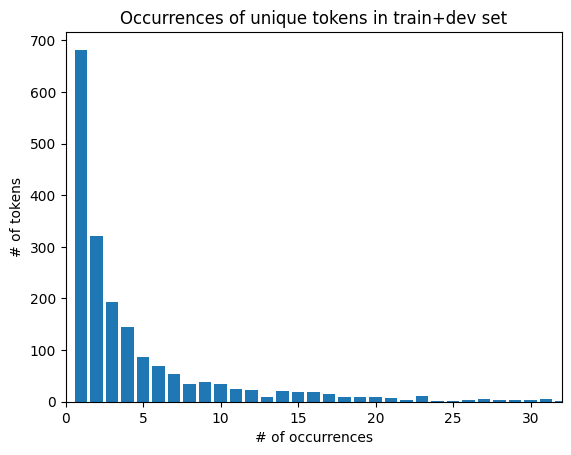

In [23]:
import matplotlib.pyplot as plt

plt.bar(x=TOKEN_COUNT_X, height=NUM_TOKENS_Y)
plt.title("Occurrences of unique tokens in train+dev set")
plt.xlabel("# of occurrences")
plt.ylabel("# of tokens")
plt.xlim(0, MAX_COUNT);

As we can see above - nearly 700 tokens occur precisely once in the entire training corpus! Let's check a cumulative count of how many unique kanji exist with less than five occurrences throughout the corpus.

In [24]:
UNCOMMON_TOKENS_COUNT = 5

chars_with_infrequent_occurrence = set()
for count in range(1, UNCOMMON_TOKENS_COUNT + 1):
    if count in train_counts:
        token_list = train_counts[count]
        chars_with_infrequent_occurrence.update(set(token_list))

print(f"Number of tokens with <= {UNCOMMON_TOKENS_COUNT} occurrences : {len(chars_with_infrequent_occurrence)}")

Number of tokens with <= 5 occurrences : 1041


## Remove Out-of-Vocabulary tokens from the test set

Previously we counted the set of Out-of-Vocabulary tokens that exist in the test set but not in the train or dev set. Now, let's remove them.

In [25]:
all_tokens = set.union(train_dev_set, test_set)
print(f"Original train+dev+test vocab size : {len(all_tokens)}")

extra_kanji = set(test_oov)
train_token_set = all_tokens - extra_kanji
print(f"New train vocab size : {len(train_token_set)}")

Original train+dev+test vocab size : 1433
New train vocab size : 1255


## Process *dakuten*

As mentioned above, Hiragana and Katakana have a base set of just 46 tokens. But by changing the pronunciation of specific tokens, which are denoted by ` ﾞ` (dakuten) or ` ﾟ` (handakuten), the meaning of the token changes. As demonstrated in [How to memorize the Hiragana Dakuten](https://en.wikibooks.org/wiki/Memorizing_the_Hiragana/Dakuten):

Normal  | With dakuten ( ﾞ )     |  with handakuten ( ﾟ )
--------|------------------------|----------------------
か = ka  |  が = ga               |
さ = sa  |  ざ = za               |
た = ta  |  だ = da               |
は = ha  |  ば = ba               |  ぱ = pa

Ordinarily, it is essential to capture the acoustic differences between the tokens described by the dakuten. However, the dataset here is so tiny that it would reduce the model's ability to learn and disambiguate between the two types of tokens.

Below, we offer a flag to replace the dakuten and handakuten with the base character set (in exchange for making the transcript incorrect).

**Note**: This option should be set to **False** for any scenario with a reasonable amount of data.

In [26]:
#@title Dakuten normalization
perform_dakuten_normalization = True #@param ["True", "False"] {type:"raw"}
PERFORM_DAKUTEN_NORMALIZATION = bool(perform_dakuten_normalization)

In [27]:
import unicodedata
def process_dakuten(text):
    normalized_text = unicodedata.normalize('NFD', text)
    normalized_text = normalized_text.replace("\u3099", "").replace("\u309A", "")
    return normalized_text

In [28]:
if PERFORM_DAKUTEN_NORMALIZATION:
    normalized_train_token_set = set()
    for token in train_token_set:
        normalized_token = process_dakuten(str(token))
        normalized_train_token_set.update(normalized_token)

    print(f"After dakuten normalization, number of train tokens : {len(normalized_train_token_set)}")
else:
    normalized_train_token_set = train_token_set


After dakuten normalization, number of train tokens : 1210


## Process special character tokens

There are several tokens which do not accurately correspond to an acoustic feature. A few examples are various commas and the period. Think of it this way, unless every sentence ends with a period (and this is uncommon - since training datasets are often comprised of small snippets of audio out of a longer conversations), then a model has insufficient context to determine when to end a sentence from just the snippet it was provided.

As such, we remove several special tokens such as commas, question marks, periods, quotation marks, and a few special tokens sometimes used in Japanese text.

In [29]:
# Preprocessing steps
import re
import unicodedata

chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\…\{\}\【\】\・\。\『\』\、\ー\〜]'  # remove special character tokens
kanji_removal_regex = '[' + "".join([f"\{token}" for token in extra_kanji]) + ']'  # remove test set kanji


def remove_special_characters(data):
    data["text"] = re.sub(chars_to_ignore_regex, '', data["text"]).lower().strip()
    return data

def remove_extra_kanji(data):
    data["text"] = re.sub(kanji_removal_regex, '', data["text"])
    return data

def remove_dakuten(data):
    # perform dakuten normalization (if it was requested)
    if PERFORM_DAKUTEN_NORMALIZATION:
        text = data['text']
        data['text'] = process_dakuten(text)
    return data

## Process dataset

Now that we have the functions necessary to clean up the transcripts, let's create a small pipeline to clean up the manifest and write new manifests for us. For simplicity's sake (as the dataset is so small), a simple sequential pipeline will be sufficient for our use case.

In [30]:
# Processing pipeline
def apply_preprocessors(manifest, preprocessors):
    for processor in preprocessors:
        for idx in tqdm(range(len(manifest)), desc=f"Applying {processor.__name__}"):
            manifest[idx] = processor(manifest[idx])

    print("Finished processing manifest !")
    return manifest

In [31]:
# List of pre-processing functions
PREPROCESSORS = [
    remove_special_characters,
    remove_extra_kanji,
    remove_dakuten,
]

In [32]:
# Load manifests
train_data = read_manifest(train_manifest)
dev_data = read_manifest(dev_manifest)
test_data = read_manifest(test_manifest)

# Apply preprocessing
train_data_processed = apply_preprocessors(train_data, PREPROCESSORS)
dev_data_processed = apply_preprocessors(dev_data, PREPROCESSORS)
test_data_processed = apply_preprocessors(test_data, PREPROCESSORS)

# Write new manifests
train_manifest_cleaned = write_processed_manifest(train_data_processed, train_manifest)
dev_manifest_cleaned = write_processed_manifest(dev_data_processed, dev_manifest)
test_manifest_cleaned = write_processed_manifest(test_data_processed, test_manifest)


Applying remove_special_characters:   0%|          | 0/722 [00:00<?, ?it/s]

Applying remove_extra_kanji:   0%|          | 0/722 [00:00<?, ?it/s]

Applying remove_dakuten:   0%|          | 0/722 [00:00<?, ?it/s]

Finished processing manifest !


Applying remove_special_characters:   0%|          | 0/586 [00:00<?, ?it/s]

Applying remove_extra_kanji:   0%|          | 0/586 [00:00<?, ?it/s]

Applying remove_dakuten:   0%|          | 0/586 [00:00<?, ?it/s]

Finished processing manifest !


Applying remove_special_characters:   0%|          | 0/632 [00:00<?, ?it/s]

Applying remove_extra_kanji:   0%|          | 0/632 [00:00<?, ?it/s]

Applying remove_dakuten:   0%|          | 0/632 [00:00<?, ?it/s]

Finished processing manifest !
Finished writing manifest: datasets/ja/mozilla-foundation/common_voice_6_1/ja/train/train_mozilla-foundation_common_voice_6_1_manifest_processed.json
Finished writing manifest: datasets/ja/mozilla-foundation/common_voice_6_1/ja/validation/validation_mozilla-foundation_common_voice_6_1_manifest_processed.json
Finished writing manifest: datasets/ja/mozilla-foundation/common_voice_6_1/ja/test/test_mozilla-foundation_common_voice_6_1_manifest_processed.json


## Final character set

After pre-processing the dataset, let's recover the final character set used to train the models.

In [33]:
train_manifest_data = read_manifest(train_manifest_cleaned)
train_charset = get_charset(train_manifest_data)

dev_manifest_data = read_manifest(dev_manifest_cleaned)
dev_charset = get_charset(dev_manifest_data)

train_dev_set = set.union(set(train_charset.keys()), set(dev_charset.keys()))

Computing character set:   0%|          | 0/722 [00:00<?, ?it/s]

Computing character set:   0%|          | 0/586 [00:00<?, ?it/s]

In [34]:
print(f"Number of tokens in preprocessed train+dev set : {len(train_dev_set)}")

Number of tokens in preprocessed train+dev set : 1206


# Character Encoding CTC Model

Now that we have a processed dataset, we can begin training an ASR model on this dataset. The following section will detail how we prepare a CTC model which utilizes a Character Encoding scheme.

This section will utilize a pre-trained [QuartzNet 15x5](https://arxiv.org/abs/1910.10261), which has been trained on roughly 7,000 hours of English speech base model. We will modify the decoder layer (thereby changing the model's vocabulary) and then train for a small number of epochs.

In [35]:
char_model = nemo_asr.models.ASRModel.from_pretrained("stt_en_quartznet15x5", map_location='cpu')

[NeMo I 2024-07-22 20:47:39 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_quartznet15x5/versions/1.0.0rc1/files/stt_en_quartznet15x5.nemo to /root/.cache/torch/NeMo/NeMo_1.23.0/stt_en_quartznet15x5/16661021d16e679bdfd97a2a03944c49/stt_en_quartznet15x5.nemo
[NeMo I 2024-07-22 20:47:46 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-07-22 20:47:47 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data2/voices/train_1k.json
    sample_rate: 16000
    labels:
    - ' '
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - ''''
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: /asr_set_1.2/train/train_{0..1023}.tar
    num_workers: 20
    
[NeMo W 2024-07-22 20:47:47 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
   

[NeMo I 2024-07-22 20:47:47 features:289] PADDING: 16
[NeMo I 2024-07-22 20:47:47 save_restore_connector:249] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/stt_en_quartznet15x5/16661021d16e679bdfd97a2a03944c49/stt_en_quartznet15x5.nemo.


## Update the vocabulary

Changing the vocabulary of a character encoding ASR model is as simple as passing the list of new tokens that comprise the vocabulary as input to `change_vocabulary()`.

In [ ]:
char_model.change_vocabulary(new_vocabulary=list(train_dev_set))

## Training on low resource languages

If the amount of training data or available computational resources are limited, it might be useful to freeze the encoder module of the network and train just the final decoder layer. This is also useful in cases where GPU memory is insufficient to train a large network, or cases where the model might overfit due to its size.

-------

In cases where sufficient data is available - and "sufficient" is dependent on the complexity of the language - then it is advised to train the encoder as well to get the best possible transcript. When we say sufficient is relative to the language, we have noticed that some languages can obtain reasonable scores with a few hundred hours of transcribed speech, whereas some languages require several thousand hours.

------

It is also important to note that if the language remains the same, and some specific domain of text must be adapted for ASR, it is often easier to add a domain-specific language model to guide the generic ASR model than to attempt fine-tuning a full ASR model on limited data from that specific domain.

In [ ]:
#@title Freeze Encoder { display-mode: "form" }
freeze_encoder = True #@param ["False", "True"] {type:"raw"}
freeze_encoder = bool(freeze_encoder)

### Frozen Encoder - Unfrozen Batch Normalization

Freezing the encoder is generally helpful to limit computation and enable faster training; however, in many experiments, freezing the encoder in its entirety will often prevent a model from learning on low-resource languages.

In order to enable a frozen encoder model to learn on a new language stably, we, therefore, unfreeze the batch normalization layers in the encoder. On top of this, if the model contains "SqueezeExcite" sub-modules, we unfreeze them as well.

In doing so, we notice that such models train properly and obtain respectable scores even on severely resource-limited languages.

------

**Note**: This phenomenon disappears when sufficient data is available (in such a case, the entire encoder can be trained as well). Therefore it is advised to unfreeze the encoder when sufficient data is available.

In [ ]:
import torch
import torch.nn as nn

def enable_bn_se(m):
    if type(m) == nn.BatchNorm1d:
        m.train()
        for param in m.parameters():
            param.requires_grad_(True)

    if 'SqueezeExcite' in type(m).__name__:
        m.train()
        for param in m.parameters():
            param.requires_grad_(True)

In [ ]:
if freeze_encoder:
  char_model.encoder.freeze()
  char_model.encoder.apply(enable_bn_se)
  logging.info("Model encoder has been frozen, and batch normalization has been unfrozen")
else:
  char_model.encoder.unfreeze()
  logging.info("Model encoder has been un-frozen")

## Update config

Each NeMo model has a config embedded in it, which can be accessed via `model.cfg`. In general, this is the config that was used to construct the model.

For pre-trained models, this config generally represents the config used to construct the model when it was trained. A nice benefit to this embedded config is that we can repurpose it to set up new data loaders, optimizers, schedulers, and even data augmentation!

### Updating the character set of the model

The most important step for preparing character encoding models for fine-tuning is to update the model's character set. Remember - the model was trained on some language with some specific dataset that had a certain character set. Character sets would rarely remain the same between training and fine-tuning (though it is still possible).

Each character encoding model has a `model.cfg.labels` attribute, which can be overridden via OmegaConf.

In [ ]:
char_model.cfg.labels = list(train_dev_set)

Now, we create a working copy of the model config and update it as needed.

In [ ]:
cfg = copy.deepcopy(char_model.cfg)

### Setting up data loaders

Now that the model's character set has been updated let's prepare the model to utilize the new character set even in the data loaders. Note that this is crucial so that the data produced during training/validation matches the new character set, and tokens are encoded/decoded correctly.

**Note**: An important config parameter is `normalize_transcripts` and `parser`. There are some parsers that are used for specific languages for character based models - currently only `en` is supported. These parsers will preprocess the text with the given languages parser. However, for other languages, it is advised to explicitly set `normalize_transcripts = False` - which will prevent the parser from processing text.

In [ ]:
# Setup train, validation, test configs
with open_dict(cfg):
  # Train dataset  (Concatenate train manifest cleaned and dev manifest cleaned)
  cfg.train_ds.manifest_filepath = f"{train_manifest_cleaned},{dev_manifest_cleaned}"
  cfg.train_ds.labels = list(train_dev_set)
  cfg.train_ds.normalize_transcripts = False
  cfg.train_ds.batch_size = 32
  cfg.train_ds.num_workers = 8
  cfg.train_ds.pin_memory = True
  cfg.train_ds.trim_silence = True

  # Validation dataset  (Use test dataset as validation, since we train using train + dev)
  cfg.validation_ds.manifest_filepath = test_manifest_cleaned
  cfg.validation_ds.labels = list(train_dev_set)
  cfg.validation_ds.normalize_transcripts = False
  cfg.validation_ds.batch_size = 8
  cfg.validation_ds.num_workers = 8
  cfg.validation_ds.pin_memory = True
  cfg.validation_ds.trim_silence = True

In [ ]:
# setup data loaders with new configs
char_model.setup_training_data(cfg.train_ds)
char_model.setup_multiple_validation_data(cfg.validation_ds)

### Setting up optimizer and scheduler

When fine-tuning character models, it is generally advised to use a lower learning rate and reduced warmup. A reduced learning rate helps preserve the pre-trained weights of the encoder. Since the fine-tuning dataset is generally smaller than the original training dataset, the warmup steps would be far too much for the smaller fine-tuning dataset.

-----
**Note**: When freezing the encoder, it is possible to use the original learning rate as the model was trained on. The original learning rate can be used because the encoder is frozen, so the learning rate is used only to optimize the decoder. However, a very high learning rate would still destabilize training, even with a frozen encoder.

In [ ]:
# Original optimizer + scheduler
print(OmegaConf.to_yaml(char_model.cfg.optim))

In [ ]:
with open_dict(char_model.cfg.optim):
  char_model.cfg.optim.lr = 0.01
  char_model.cfg.optim.betas = [0.95, 0.5]  # from paper
  char_model.cfg.optim.weight_decay = 0.001  # Original weight decay
  char_model.cfg.optim.sched.warmup_steps = None  # Remove default number of steps of warmup
  char_model.cfg.optim.sched.warmup_ratio = 0.05  # 5 % warmup
  char_model.cfg.optim.sched.min_lr = 1e-5

### Setting up augmentation

Remember that the model was trained on several thousands of hours of data, so the regularization provided to it might not suit the current dataset. We can easily change it as we see fit.

-----

You might notice that we utilize `char_model.from_config_dict()` to create a new SpectrogramAugmentation object and assign it directly in place of the previous augmentation. This is generally the syntax to be followed whenever you notice a `_target_` tag in the config of a model's inner config.

-----
**Note**: For low resource languages, it might be better to increase augmentation via SpecAugment to reduce overfitting. However, this might, in turn, make it too hard for the model to train in a short number of epochs.

In [ ]:
print(OmegaConf.to_yaml(char_model.cfg.spec_augment))

In [ ]:
# with open_dict(char_model.cfg.spec_augment):
#   char_model.cfg.spec_augment.freq_masks = 2
#   char_model.cfg.spec_augment.freq_width = 25
#   char_model.cfg.spec_augment.time_masks = 2
#   char_model.cfg.spec_augment.time_width = 0.05

char_model.spec_augmentation = char_model.from_config_dict(char_model.cfg.spec_augment)

## Setup Metrics

Originally, the model was trained on an English dataset corpus. When calculating Word Error Rate, we can easily use the "space" token as a separator for word boundaries. On the other hand, certain languages such as Japanese and Mandarin do not use "space" tokens, instead opting for different ways to annotate the end of the word.

In cases where the "space" token is not used to denote a word boundary, we can use the Character Error Rate metric instead, which computes the edit distance at a token level rather than a word level.

We might also be interested in noting model predictions during training and inference. As such, we can enable logging of the predictions.

In [ ]:
#@title Metric
use_cer = True #@param ["False", "True"] {type:"raw"}
log_prediction = True #@param ["False", "True"] {type:"raw"}



In [ ]:
char_model.wer.use_cer = use_cer
char_model.wer.log_prediction = log_prediction

## Setup Trainer and Experiment Manager

And that's it! Now we can train the model by simply using the Pytorch Lightning Trainer and NeMo Experiment Manager as always.

For demonstration purposes, the number of epochs is kept intentionally low. Reasonable results can be obtained in around 100 epochs (approximately 25 minutes on Colab GPUs).

In [ ]:
import torch
import pytorch_lightning as ptl

if torch.cuda.is_available():
  accelerator = 'gpu'
else:
  accelerator = 'cpu'

EPOCHS = 50  # 100 epochs would provide better results, but would take an hour to train

trainer = ptl.Trainer(devices=1,
                      accelerator=accelerator,
                      max_epochs=EPOCHS,
                      accumulate_grad_batches=1,
                      enable_checkpointing=False,
                      logger=False,
                      log_every_n_steps=5,
                      check_val_every_n_epoch=10)

# Setup model with the trainer
char_model.set_trainer(trainer)

# Finally, update the model's internal config
char_model.cfg = char_model._cfg

In [ ]:
# Environment variable generally used for multi-node multi-gpu training.
# In notebook environments, this flag is unnecessary and can cause logs of multiple training runs to overwrite each other.
os.environ.pop('NEMO_EXPM_VERSION', None)

config = exp_manager.ExpManagerConfig(
    exp_dir=f'experiments/lang-{LANGUAGE}/',
    name=f"ASR-Char-Model-Language-{LANGUAGE}",
    checkpoint_callback_params=exp_manager.CallbackParams(
        monitor="val_wer",
        mode="min",
        always_save_nemo=True,
        save_best_model=True,
    ),
)

config = OmegaConf.structured(config)

logdir = exp_manager.exp_manager(trainer, config)

In [ ]:
try:
  from google import colab
  COLAB_ENV = True
except (ImportError, ModuleNotFoundError):
  COLAB_ENV = False

# Load the TensorBoard notebook extension
if COLAB_ENV:
  %load_ext tensorboard
  %tensorboard --logdir /content/experiments/lang-$LANGUAGE/ASR-Char-Model-Language-$LANGUAGE/
else:
  print("To use tensorboard, please use this notebook in a Google Colab environment.")

In [ ]:
%%time
trainer.fit(char_model)

## Results

Whether you trained for small number of epochs, the character word error rate seems high (even after 100 epochs, CER is close to 45-50% or so on the test set).

Considering the limited amount of data available and the extensive vocabulary, this is expected to some degree. Remember that nearly 177 tokens were out of vocabulary in the test set - so those acoustic features can't be adequately captured using just the train set tokens.

For reference, AISHELL datasets comprise some few hundred to one thousand hours of Mandarin speech to train roughly 5600 tokens, and those models are generally trained for a very long time on multi GPU setups.

# Sub-word Encoding CTC Model

Sub-word encoding models are almost nearly identical to the Character encoding models. The primary difference lies in the fact that a sub-encoding model accepts a sub-word tokenized text corpus and emits sub-word tokens in its decoding step. The following section will detail how we prepare a CTC model which utilizes a sub-word Encoding scheme.

For this section, we will utilize a pre-trained [Citrinet 512](https://arxiv.org/abs/2104.01721) trained on roughly 7,000 hours of English speech as the base model. We will modify the decoder layer (thereby changing the model's vocabulary) and then train for a small number of epochs.

## Prepare Tokenizer

Before we update the vocabulary of the model, first, we need to construct a tokenizer. NeMo supports both Word Piece Tokenizer (via HuggingFace) or Sentence Piece Tokenizer (via Google SentencePiece library). We will utilize the SentencePiece tokenizer in this tutorial.

-----
Preparation of the tokenizer is made simple by the `process_asr_text_tokenizer.py` script in NeMo. We will leverage this script to build the text corpus from the manifest directly, then create a tokenizer using that corpus.

**Note**: Ordinarily, for languages that have such substantially large vocabularies, there is no significant benefit obtained by constructing sub-word vocabulary. In Natural Language Processing, we could use enormous vocabulary sizes of 10,000+ tokens, but that is unfeasible for CTC loss training of ASR models.

Therefore, we will construct a sub-word tokenizer with vocabulary size exactly the same as the character encoding model plus add a few tokens required by SentencePiece required to perform tokenization. You can experiment with the effect of larger vocabularies by editing `VOCAB_SIZE` below.

## Making new tokenizer

In [42]:
if not os.path.exists("scripts/process_asr_text_tokenizer.py"):
  !wget -P scripts/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tokenizers/process_asr_text_tokenizer.py

In [43]:
#@title Tokenizer Config { display-mode: "form" }
TOKENIZER_TYPE = "bpe" #@param ["bpe", "unigram"]

You might wonder, why do we need `len(train_dev_set) + 2` as the minimum`VOCAB_SIZE`. The answer is that we are utilizing the SentencePiece implementation of the Byte Pair Tokenization algorithm.

In this case, the byte piece tokenizer requires *at least two tokens* - `<unk>` and `_`. SentencePiece represents `<unk>` using the `⁇` token.

In [44]:
# << VOCAB SIZE can be changed to any value larger than (len(train_dev_set) + 2)! >>
# VOCAB_SIZE = len(train_dev_set) + 2
VOCAB_SIZE = 128

Most of the arguments are similar to those explained in the `ASR with Subword Tokenization notebook`.

------

You will note that there is an argument `spe_character_coverage=1.0`. This value means that 100% of the base character set (1200~ tokens) must be present in the tokenizer vocab. However, for languages like Japanese and Mandarin, we notice that many tokens occur very infrequently (nearly 1000 tokens appear fewer than five times in the entire training set !), so we can suggest to SentencePiece tokenizer that we are alright with dropping up to 2% of the original character set and replace then with `⁇` (which represent the `UNK` token for SPE).

In [47]:
train_manifest_cleaned = "/workspace/dataset/train_clean/manifest.json"
dev_manifest_cleaned = "/workspace/dataset/validation/manifest.json"

In [50]:
tokenizer_dir = "/workspace/nemo/NeMo-opensource/tutorials/asr/tokenizers/av_tokenizer"

In [51]:
!python scripts/process_asr_text_tokenizer.py \
  --manifest=$train_manifest_cleaned,$dev_manifest_cleaned \
  --vocab_size=128 \
  --data_root=$tokenizer_dir \
  --tokenizer="spe" \
  --spe_type=$TOKENIZER_TYPE \
  --spe_character_coverage=1.0 \
  --no_lower_case \
  --log

INFO:root:Finished extracting manifest : /workspace/dataset/train_clean/manifest.json
INFO:root:Finished extracting manifest : /workspace/dataset/validation/manifest.json
INFO:root:Finished extracting all manifests ! Number of sentences : 236954
[NeMo I 2024-07-18 18:51:58 sentencepiece_tokenizer:316] Processing /workspace/nemo/NeMo-opensource/tutorials/asr/tokenizers/av_tokenizer/text_corpus/document.txt and store at /workspace/nemo/NeMo-opensource/tutorials/asr/tokenizers/av_tokenizer/tokenizer_spe_bpe_v128
sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=/workspace/nemo/NeMo-opensource/tutorials/asr/tokenizers/av_tokenizer/text_corpus/document.txt --model_prefix=/workspace/nemo/NeMo-opensource/tutorials/asr/tokenizers/av_tokenizer/tokenizer_spe_bpe_v128/tokenizer --vocab_size=128 --shuffle_input_sentence=true --hard_vocab_limit=false --model_type=bpe --character_coverage=1.0 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
traine

In [52]:
TOKENIZER_DIR = f"{tokenizer_dir}/tokenizer_spe_{TOKENIZER_TYPE}_v{VOCAB_SIZE}/"
print("Tokenizer directory :", TOKENIZER_DIR)

Tokenizer directory : /workspace/nemo/NeMo-opensource/tutorials/asr/tokenizers/av_tokenizer/tokenizer_spe_bpe_v228/


In [79]:
# tokens is a list of <N1>, <N2>, ... <N128> tokens
tokens = [f"<N{i}>" for i in range(1, 228 + 1)] # Just added 228 tokens, you can add more
tokens_string = """' '""".join(tokens)
tokens_string = f"'{tokens_string}'"
print(f"Tokens : {tokens_string}")

Tokens : '<N1>' '<N2>' '<N3>' '<N4>' '<N5>' '<N6>' '<N7>' '<N8>' '<N9>' '<N10>' '<N11>' '<N12>' '<N13>' '<N14>' '<N15>' '<N16>' '<N17>' '<N18>' '<N19>' '<N20>' '<N21>' '<N22>' '<N23>' '<N24>' '<N25>' '<N26>' '<N27>' '<N28>' '<N29>' '<N30>' '<N31>' '<N32>' '<N33>' '<N34>' '<N35>' '<N36>' '<N37>' '<N38>' '<N39>' '<N40>' '<N41>' '<N42>' '<N43>' '<N44>' '<N45>' '<N46>' '<N47>' '<N48>' '<N49>' '<N50>' '<N51>' '<N52>' '<N53>' '<N54>' '<N55>' '<N56>' '<N57>' '<N58>' '<N59>' '<N60>' '<N61>' '<N62>' '<N63>' '<N64>' '<N65>' '<N66>' '<N67>' '<N68>' '<N69>' '<N70>' '<N71>' '<N72>' '<N73>' '<N74>' '<N75>' '<N76>' '<N77>' '<N78>' '<N79>' '<N80>' '<N81>' '<N82>' '<N83>' '<N84>' '<N85>' '<N86>' '<N87>' '<N88>' '<N89>' '<N90>' '<N91>' '<N92>' '<N93>' '<N94>' '<N95>' '<N96>' '<N97>' '<N98>' '<N99>' '<N100>' '<N101>' '<N102>' '<N103>' '<N104>' '<N105>' '<N106>' '<N107>' '<N108>' '<N109>' '<N110>' '<N111>' '<N112>' '<N113>' '<N114>' '<N115>' '<N116>' '<N117>' '<N118>' '<N119>' '<N120>' '<N121>' '<N122>' '

In [80]:
# ! protoc --python_out=/workspace/nemo/NeMo-opensource/scripts/tokenizers/ sentencepiece_model.proto

!python /workspace/nemo/NeMo-opensource/scripts/tokenizers/add_special_tokens_to_sentencepiece.py \
--input_file /workspace/nemo/NeMo-opensource/tutorials/asr/tokenizers/av_tokenizer/tokenizer_spe_bpe_v128/tokenizer.model \
--output_file /workspace/nemo/NeMo-opensource/tutorials/asr/tokenizers/av_tokenizer/tokenizer_spe_bpe_v128/tokenizer_new.model\
--is_userdefined \
--tokens $tokens_string

INFO: Created token '<N1>' at ID 128
INFO: Created token '<N2>' at ID 129
INFO: Created token '<N3>' at ID 130
INFO: Created token '<N4>' at ID 131
INFO: Created token '<N5>' at ID 132
INFO: Created token '<N6>' at ID 133
INFO: Created token '<N7>' at ID 134
INFO: Created token '<N8>' at ID 135
INFO: Created token '<N9>' at ID 136
INFO: Created token '<N10>' at ID 137
INFO: Created token '<N11>' at ID 138
INFO: Created token '<N12>' at ID 139
INFO: Created token '<N13>' at ID 140
INFO: Created token '<N14>' at ID 141
INFO: Created token '<N15>' at ID 142
INFO: Created token '<N16>' at ID 143
INFO: Created token '<N17>' at ID 144
INFO: Created token '<N18>' at ID 145
INFO: Created token '<N19>' at ID 146
INFO: Created token '<N20>' at ID 147
INFO: Created token '<N21>' at ID 148
INFO: Created token '<N22>' at ID 149
INFO: Created token '<N23>' at ID 150
INFO: Created token '<N24>' at ID 151
INFO: Created token '<N25>' at ID 152
INFO: Created token '<N26>' at ID 153
INFO: Created token '

In [81]:
import sentencepiece as spm

sp = spm.SentencePieceProcessor()
sp.load('/workspace/nemo/NeMo-opensource/tutorials/asr/tokenizers/av_tokenizer/tokenizer_spe_bpe_v128/tokenizer_new.model')

vocab_list = [sp.id_to_piece(i) for i in range(sp.get_piece_size())]
# Save the vocabulary to a file
with open('new_tokenizer.vocab', 'w') as vocab_file:
    for token in vocab_list:
        vocab_file.write(token + '\n')


In [84]:
# Updating vocab.txt
vocab_file = '/workspace/nemo/NeMo-opensource/tutorials/asr/tokenizers/av_tokenizer/tokenizer_spe_bpe_v128/vocab.txt'
new_vocab_file = '/workspace/nemo/NeMo-opensource/tutorials/asr/tokenizers/av_tokenizer/tokenizer_spe_bpe_v128/new_vocab.txt'
# read the existing vocab file and add <N1>, <N2>, ... <N128> tokens
with open(vocab_file, 'r') as f:
    lines = f.readlines()

# Add the new tokens to the vocab file
with open(new_vocab_file, 'w') as f:
    for line in lines:
        f.write(line)
    for token in tokens:
        f.write(token + '\n')

In [59]:
!cp new_tokenizer.vocab /workspace/nemo/NeMo-opensource/tutorials/asr/tokenizers/av_tokenizer/tokenizer_spe_bpe_v128/

When using the `unigram` tokenizer, for certain languages, it is possible to request a tokenizer vocab size larger than the number of unique unigram subwords that can be built from the text corpus. This happens more frequently in low-resource languages where a very small number of transcripts exist.

So we perform a check, asserting that the number of tokens in the vocabulary is >= the VOCAB_SIZE.

In [61]:
# Number of tokens in tokenizer -
with open(os.path.join(TOKENIZER_DIR, 'tokenizer.vocab')) as f:
  tokens = f.readlines()

num_tokens = len(tokens)
print("Number of tokens : ", num_tokens)

Number of tokens :  128


In [62]:
if num_tokens < VOCAB_SIZE:
    print(
        f"The text in this dataset is too small to construct a tokenizer "
        f"with vocab size = {VOCAB_SIZE}. Current number of tokens = {num_tokens}. "
        f"Please reconstruct the tokenizer with fewer tokens"
    )

The text in this dataset is too small to construct a tokenizer with vocab size = 228. Current number of tokens = 128. Please reconstruct the tokenizer with fewer tokens


## Load pre-trained model

Here we will load a pre-trained Citrinet 512. The model possesses nearly twice the parameter count of QuartzNet, and has a larger receptive field due to its three stride layers (effectively striding the temporal dimension by 8x).

In [ ]:
model = nemo_asr.models.ASRModel.from_pretrained("stt_en_citrinet_512", map_location='cpu')

## Preserving decoder initialization for sub-word models

Subword tokenization has an interesting phenomenon. In many languages, the base character set is small enough that many sub-words can be computed to produce a finite-sized tokenizer vocabulary (the model above has a vocabulary size of 1024 Byte Pair subwords). When preparing the tokenizer on a fine-tuning corpus, it might be possible to once again prepare a tokenizer with exactly the same number of tokens (say 1024).

In such a case, the weight matrices of the decoder match exactly, and therefore the pre-trained weights of the original model can be loaded onto the new model! This is treated as a good initialization only since further gradient updates will update significantly change the alignments of the decoder. However, we find that such an initialization sometimes significantly improves word error rate and slightly improved convergence speed.

-----
**Note**: While this approach applies to many languages, it cannot be used for languages where the base character set is larger than the previous tokenizer vocab size (say for Japanese or Mandarin where the number of base characters is larger than the original tokenizer vocabulary size itself).

In [ ]:
# Preserve the decoder parameters in case weight matching can be done later
pretrained_decoder = model.decoder.state_dict()

## Update the vocabulary

Changing the vocabulary of a sub-word encoding ASR model is as simple as passing the path of the tokenizer dir to `change_vocabulary()`.

In [ ]:
model.change_vocabulary(new_tokenizer_dir=TOKENIZER_DIR, new_tokenizer_type="bpe")

## Restore decoder weights (if possible)

As mentioned above, if the new vocabulary size matches the old vocabulary size, it is possible to restore the decoder weights in addition to the encoder weights.

The following snippet checks the weight shapes and then attempts to restore the parameters of the decoder.

In [ ]:
# Insert preserved model weights if shapes match
if model.decoder.decoder_layers[0].weight.shape == pretrained_decoder['decoder_layers.0.weight'].shape:
    model.decoder.load_state_dict(pretrained_decoder)
    logging.info("Decoder shapes matched - restored weights from pre-trained model")
else:
    logging.info("\nDecoder shapes did not match - could not restore decoder weights from pre-trained model.")

## Frozen Encoder - Unfrozen Batch Normalization

Similar to the Character-based models, we can freeze the encoder and unfreeze the batch normalization layers if the dataset is tiny.

In [ ]:
#@title Freeze Encoder { display-mode: "form" }
freeze_encoder = True #@param ["False", "True"] {type:"raw"}
freeze_encoder = bool(freeze_encoder)

In [ ]:
if freeze_encoder:
  model.encoder.freeze()
  model.encoder.apply(enable_bn_se)
  logging.info("Model encoder has been frozen")
else:
  model.encoder.unfreeze()
  logging.info("Model encoder has been un-frozen")

## Update config

Similar to the character encoding CTC model above, we will update the config for the sub-word encoding model.

It is primarily the data loaders that will be affected by the switch from character encoding to sub-word encoding.

In [ ]:
cfg = copy.deepcopy(model.cfg)

### Setup tokenizer

This step is merely for demonstration - when we updated the tokenizer previously using `change_vocabulary()`, it internally performed this step as well.

In [ ]:
# Setup new tokenizer
cfg.tokenizer.dir = TOKENIZER_DIR
cfg.tokenizer.type = "bpe"

# Set tokenizer config
model.cfg.tokenizer = cfg.tokenizer

### Setup data loaders

While significant sections remain the same between character-based and sub-word-based model configs - the data loaders are the main area where they diverge.

The sub-word encoding models do not require a "model.cfg.labels" section. In fact, their data loaders do not require `labels` at all! The labels are automatically extracted from the provided tokenizer, and the data loaders and updated implicitly.

In [ ]:
# Setup train/val/test configs
print(OmegaConf.to_yaml(cfg.train_ds))

In [ ]:
# Setup train, validation, test configs
with open_dict(cfg):
  # Train dataset
  cfg.train_ds.manifest_filepath = f"{train_manifest_cleaned},{dev_manifest_cleaned}"
  cfg.train_ds.batch_size = 32
  cfg.train_ds.num_workers = 8
  cfg.train_ds.pin_memory = True
  cfg.train_ds.use_start_end_token = True
  cfg.train_ds.trim_silence = True

  # Validation dataset
  cfg.validation_ds.manifest_filepath = test_manifest_cleaned
  cfg.validation_ds.batch_size = 8
  cfg.validation_ds.num_workers = 8
  cfg.validation_ds.pin_memory = True
  cfg.validation_ds.use_start_end_token = True
  cfg.validation_ds.trim_silence = True

  # Test dataset
  cfg.test_ds.manifest_filepath = test_manifest_cleaned
  cfg.test_ds.batch_size = 8
  cfg.test_ds.num_workers = 8
  cfg.test_ds.pin_memory = True
  cfg.test_ds.use_start_end_token = True
  cfg.test_ds.trim_silence = True

In [ ]:
# setup model with new configs
model.setup_training_data(cfg.train_ds)
model.setup_multiple_validation_data(cfg.validation_ds)
model.setup_multiple_test_data(cfg.test_ds)

### Examine dataset outliers

In general, there are minor differences between the Character encoding and Sub-word encoding models. Since sub-words can encode larger sequence of tokens into a single subword, they substantially reduce the target sequence length.

Citrinet takes advantage of this reduction by aggressively downsampling the input three times (a total of 8x downsampling). At this level of downsampling, it is possible to encounter a specific limitation of CTC loss.

-----

CTC loss works under the assumption that $T$ (the acoustic model's output sequence length) $> U$ (the target sequence length). If this criterion is violated, CTC loss is practically set to $\infty$ (which is then forced to $0$ by PyTorch's `zero_infinity` flag), and its gradient is set to 0.

Therefore it is essential to inspect the ratio of $\frac{T}{U}$ and ensure that it's reasonably close to 1 or higher.



In [ ]:
def analyse_ctc_failures_in_model(model):
    count_ctc_failures = 0
    am_seq_lengths = []
    target_seq_lengths = []

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = model.to(device)
    mode = model.training

    train_dl = model.train_dataloader()

    with torch.no_grad():
      model = model.eval()
      for batch in tqdm(train_dl, desc='Checking for CTC failures'):
          x, x_len, y, y_len = batch
          x, x_len = x.to(device), x_len.to(device)
          x_logprobs, x_len, greedy_predictions = model(input_signal=x, input_signal_length=x_len)

          # Find how many CTC loss computation failures will occur
          for xl, yl in zip(x_len, y_len):
              if xl <= yl:
                  count_ctc_failures += 1

          # Record acoustic model lengths=
          am_seq_lengths.extend(x_len.to('cpu').numpy().tolist())

          # Record target sequence lengths
          target_seq_lengths.extend(y_len.to('cpu').numpy().tolist())

          del x, x_len, y, y_len, x_logprobs, greedy_predictions

    if mode:
      model = model.train()

    return count_ctc_failures, am_seq_lengths, target_seq_lengths

In [ ]:
results = analyse_ctc_failures_in_model(model)

In [ ]:
num_ctc_failures, am_seq_lengths, target_seq_lengths = results

In [ ]:
if num_ctc_failures > 0:
  logging.warning(f"\nCTC loss will fail for {num_ctc_failures} samples ({num_ctc_failures * 100./ float(len(am_seq_lengths))} % of samples)!\n"
                  f"Increase the vocabulary size of the tokenizer so that this number becomes close to zero !")
else:
  logging.info("No CTC failure cases !")

In [ ]:
# Compute average ratio of T / U
avg_T = sum(am_seq_lengths) / float(len(am_seq_lengths))
avg_U = sum(target_seq_lengths) / float(len(target_seq_lengths))

avg_length_ratio = 0
for am_len, tgt_len in zip(am_seq_lengths, target_seq_lengths):
  avg_length_ratio += (am_len / float(tgt_len))
avg_length_ratio = avg_length_ratio / len(am_seq_lengths)

print(f"Average Acoustic model sequence length = {avg_T}")
print(f"Average Target sequence length = {avg_U}")
print()
print(f"Ratio of Average AM sequence length to target sequence length = {avg_length_ratio}")

### Setup optimizer and scheduler

Similar to the character encoding model, we slightly reduce the learning rate when fine-tuning.

In [ ]:
print(OmegaConf.to_yaml(cfg.optim))

Reduce learning rate and warmup if required

Optimizer and scheduler will be automatically instantiated from this config during training.

In [ ]:
with open_dict(model.cfg.optim):
  model.cfg.optim.lr = 0.025
  model.cfg.optim.weight_decay = 0.001
  model.cfg.optim.sched.warmup_steps = None  # Remove default number of steps of warmup
  model.cfg.optim.sched.warmup_ratio = 0.10  # 10 % warmup
  model.cfg.optim.sched.min_lr = 1e-9

### Setup data augmentation

We also increase the SpecAugment masks to prevent overfitting (since it is a larger model).

In [ ]:
with open_dict(model.cfg.spec_augment):
  model.cfg.spec_augment.freq_masks = 2
  model.cfg.spec_augment.freq_width = 25
  model.cfg.spec_augment.time_masks = 10
  model.cfg.spec_augment.time_width = 0.05

model.spec_augmentation = model.from_config_dict(model.cfg.spec_augment)

## Setup Metrics

We once again use Character Error Rate (CER) instead of Word Error Rate (WER) since Japanese tokens (even when sub-word encoded) still should be treated as individual tokens after the sub-words are decoded into characters.

In [ ]:
#@title Metric
use_cer = True #@param ["False", "True"] {type:"raw"}
log_prediction = True #@param ["False", "True"] {type:"raw"}



In [ ]:
model.wer.use_cer = use_cer
model.wer.log_prediction = log_prediction

## Setup Trainer and Experiment Manager

And that's it! Now we can train the model by simply using the Pytorch Lightning Trainer and NeMo Experiment Manager as always.

For demonstration purposes, the number of epochs can be reduced. Reasonable results can be obtained in around 100 epochs (approximately 25 minutes on Colab GPUs).

In [ ]:
import torch
import pytorch_lightning as ptl

if torch.cuda.is_available():
  accelerator = 'gpu'
else:
  accelerator = 'gpu'

EPOCHS = 50  # 100 epochs would provide better results

trainer = ptl.Trainer(devices=1,
                      accelerator=accelerator,
                      max_epochs=EPOCHS,
                      accumulate_grad_batches=1,
                      enable_checkpointing=False,
                      logger=False,
                      log_every_n_steps=5,
                      check_val_every_n_epoch=10)

# Setup model with the trainer
model.set_trainer(trainer)

# finally, update the model's internal config
model.cfg = model._cfg

In [ ]:
from nemo.utils import exp_manager

# Environment variable generally used for multi-node multi-gpu training.
# In notebook environments, this flag is unnecessary and can cause logs of multiple training runs to overwrite each other.
os.environ.pop('NEMO_EXPM_VERSION', None)

config = exp_manager.ExpManagerConfig(
    exp_dir=f'experiments/lang-{LANGUAGE}/',
    name=f"ASR-Model-Language-{LANGUAGE}",
    checkpoint_callback_params=exp_manager.CallbackParams(
        monitor="val_wer",
        mode="min",
        always_save_nemo=True,
        save_best_model=True,
    ),
)

config = OmegaConf.structured(config)

logdir = exp_manager.exp_manager(trainer, config)

In [ ]:
try:
  from google import colab
  COLAB_ENV = True
except (ImportError, ModuleNotFoundError):
  COLAB_ENV = False

# Load the TensorBoard notebook extension
if COLAB_ENV:
  %load_ext tensorboard
  %tensorboard --logdir /content/experiments/lang-$LANGUAGE/ASR-Model-Language-$LANGUAGE/
else:
  print("To use tensorboard, please use this notebook in a Google Colab environment.")

In [ ]:
%%time
trainer.fit(model)

# Save the final model

Finally, we can save a checkpoint (which can be downloaded from the file browser tab on a colab environment).

In [ ]:
save_path = f"Model-{LANGUAGE}.nemo"
model.save_to(f"{save_path}")
print(f"Model saved at path : {os.getcwd() + os.path.sep + save_path}")

# Conclusion

This tutorial discussed the generic steps to prepare a dataset in a different language, prepared two models for fine-tuning, and discussed some additional insights for fine-tuning CTC-based models.

While the focus was on a small dataset for Japanese, nearly all of this information can be used for larger datasets and other scenarios where compute is limited, or the model's size prevents fine-tuning the entire model.